In [1]:
import os
from os.path import join, exists, basename, dirname, expanduser
from glob import glob
import numpy as np
import pandas as pd
import rasterio as rio
from tqdm import tqdm, tqdm_notebook
import matplotlib.pyplot as plt
import pickle
import copy
from sklearn.linear_model import LinearRegression, HuberRegressor

In [2]:
data_dir = '/bsuscratch/zacharykeskinen/data/uavsar/images'
fig_dir = expanduser('~/uavsar/figures/coherence_collections/')
pol_cols = {'VV':'red', 'VH':'green','HV':'aqua','HH':'blue'}
np.random.seed(20220503)

def lm_text(X, y):
    X = X.values.reshape(-1, 1)
    y = y.values
    lm = HuberRegressor().fit(X, y)
    r = round(lm.score(X, y), 3)
    return f'coh = {round(lm.coef_[0], 4)} * days_between + {round(lm.intercept_, 4)} @ r = {r}', lm

def lm_line(lm, x_lims):
    x = np.linspace(x_lims[0], x_lims[1], 1000)
    y = lm.coef_[0]* x + lm.intercept_
    return x, y

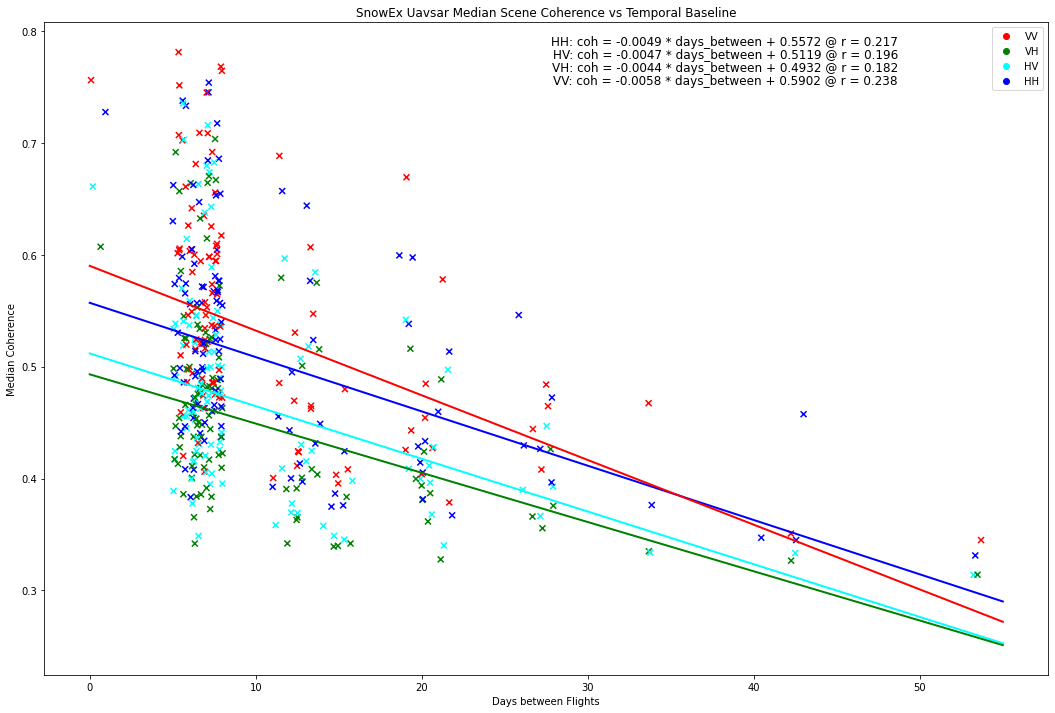

In [4]:
with open(expanduser('~/uavsar/results/time_coh/res_df_full'), 'rb') as f:
    res = pickle.load(f)
# res = res[(res.pol == 'VH') | (res.pol == 'HH')]
pol_cs = [pol_cols[i] for i in res.pol]
f, ax = plt.subplots(figsize = (18,12))
jitter = np.random.random(len(res.diff_dt))
# plt.vlines(x = res.diff_dt + jitter, ymin = res['coh_25'], ymax = res['coh_75'], colors = pol_cs, alpha = 0.3)
plt.scatter(x = res.diff_dt + jitter, y = res.median_coh, marker = 'x', c = pol_cs)
# plt.xscale('log')

# The following two lines generate custom fake lines that will be used as legend entries:
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
i = 0
for pol in np.unique(res.pol.values):
# Add lm text
    s, lm = lm_text(res[res.pol == pol].diff_dt, y = res[res.pol == pol].median_coh)
    s = f'{pol}: ' + s
    plt.text(0.85, 0.98 - i, s, ha='right', va='top', transform=ax.transAxes, fontdict = {'size': 12})
    i += 0.02
    x, y = lm_line(lm, (0, 55))
    plt.plot(x,y, color = pol_cols[pol], linewidth = 2)

plt.xlabel('Days between Flights')
plt.ylabel('Median Coherence')
plt.title('SnowEx Uavsar Median Scene Coherence vs Temporal Baseline')
# plt.xlim(4,9)
plt.savefig(join(fig_dir, 'time_pol_coh.png'), dpi = 300)

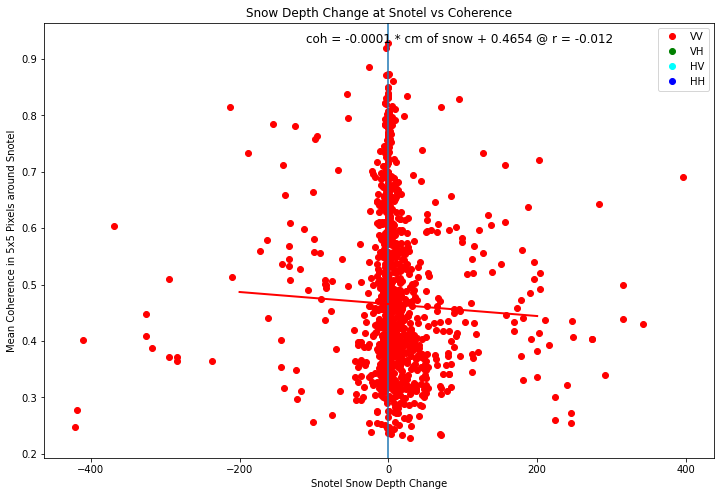

<Figure size 432x288 with 0 Axes>

In [5]:
with open(expanduser('~/uavsar/results/coherence/coh_snotel_sd/res_df_full'), 'rb') as f:
    res = pickle.load(f)
f, ax = plt.subplots(figsize = (12,8))
x = []
y = []
for i,r in res.iterrows():
    for stat in r.meso_result:
        if r.pol == 'VV':
            # d_sd = r.meso_result[stat]['delta_sd']
            d_sd = r.meso_result[stat]['delta_snow_depth'] * 100
            x.append(d_sd)
            coh = r.meso_result[stat]['img_arr_mean']
            y.append(coh)
            plt.scatter(d_sd, coh, c = pol_cols[r.pol], alpha = 1)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
plt.axvline(0)

x = [i for i in x if i is not np.nan]
y = [i for i in y if i is not np.nan]
x = pd.Series(x)
y = pd.Series(y)
lm = HuberRegressor().fit(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel())
r = round(lm.score(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel()), 3)
s =  f'coh = {round(lm.coef_[0], 4)} * cm of snow + {round(lm.intercept_, 4)} @ r = {r}'
plt.text(0.85, 0.98, s, ha='right', va='top', transform=ax.transAxes, fontdict = {'size': 12})
x, y = lm_line(lm, (-200, 200))
plt.plot(x,y, color = pol_cols['VV'], linewidth = 2)

plt.xlabel('Snotel Snow Depth Change')
plt.ylabel('Mean Coherence in 5x5 Pixels around Snotel')
plt.title('Snow Depth Change at Snotel vs Coherence')
# plt.xlim(-100,100)
plt.show()
plt.savefig(join(fig_dir, 'sd_diff_coh.png'), dpi = 300)

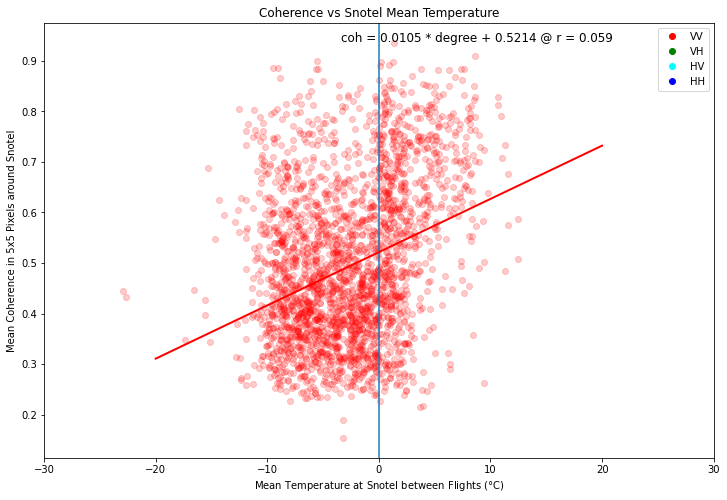

<Figure size 432x288 with 0 Axes>

In [6]:
with open(expanduser('~/uavsar/results/coherence/coh_snotel_temp/res_df_mean'), 'rb') as f:
    res = pickle.load(f)
f, ax = plt.subplots(figsize = (12,8))
x = []
y = []
for i,r in res.iterrows():
    for stat in r.meso_result:
        if r.pol == 'VV':
            # d_sd = r.meso_result[stat]['delta_sd']
            d_sd = r.meso_result[stat]['mean_air_temp']
            x.append(d_sd)
            coh = r.meso_result[stat]['img_arr_mean']
            y.append(coh)
            plt.scatter(d_sd, coh, c = pol_cols[r.pol], alpha = 0.2)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
plt.axvline(0)

x = [i for i in x if i is not np.nan]
y = [i for i in y if i is not np.nan]
x = pd.Series(x)
y = pd.Series(y)
lm = HuberRegressor().fit(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel())
r = round(lm.score(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel()), 3)
s =  f'coh = {round(lm.coef_[0], 4)} * degree + {round(lm.intercept_, 4)} @ r = {r}'
plt.text(0.85, 0.98, s, ha='right', va='top', transform=ax.transAxes, fontdict = {'size': 12})
x, y = lm_line(lm, (-20, 20))
plt.plot(x,y, color = pol_cols['VV'], linewidth = 2)

plt.xlabel('Mean Temperature at Snotel between Flights ($\degree$C)')
plt.ylabel('Mean Coherence in 5x5 Pixels around Snotel')
plt.title('Coherence vs Snotel Mean Temperature')
plt.xlim(-30,30)
plt.show()
plt.savefig(join(fig_dir, 'temp_mean_coh.png'), dpi = 300)

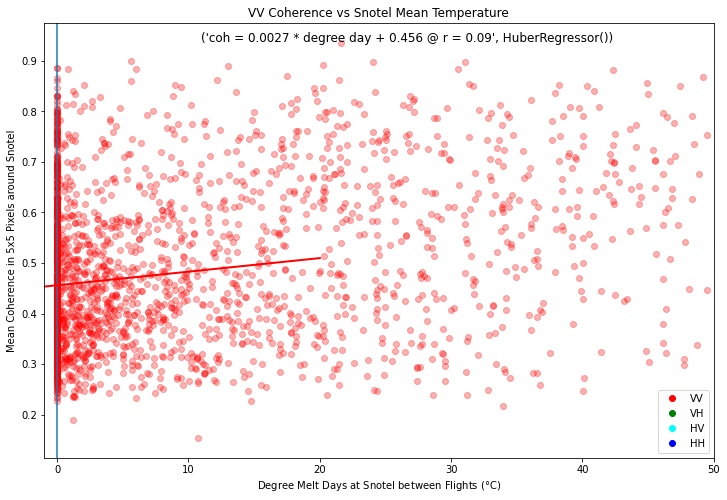

In [7]:
with open(expanduser('~/uavsar/results/coherence/coh_snotel_temp/res_df_dmd'), 'rb') as f:
    res = pickle.load(f)
f, ax = plt.subplots(figsize = (12,8))
x = []
y = []
for i,r in res.iterrows():
    for stat in r.meso_result:
        if r.pol == 'VV':
            # d_sd = r.meso_result[stat]['delta_sd']
            d_sd = r.meso_result[stat]['degmeltday_air_temp']
            x.append(d_sd)
            coh = r.meso_result[stat]['img_arr_mean']
            y.append(coh)
            plt.scatter(d_sd, coh, c = pol_cols[r.pol], alpha = 0.3)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
plt.axvline(0)

x = [i for i in x if i is not np.nan]
y = [i for i in y if i is not np.nan]
x = pd.Series(x)
y = pd.Series(y)
lm = HuberRegressor().fit(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel())
r = round(lm.score(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel()), 3)
s =  f'coh = {round(lm.coef_[0], 4)} * degree day + {round(lm.intercept_, 4)} @ r = {r}', lm
plt.text(0.85, 0.98, s, ha='right', va='top', transform=ax.transAxes, fontdict = {'size': 12})
x, y = lm_line(lm, (-20, 20))
plt.plot(x,y, color = pol_cols['VV'], linewidth = 2)

plt.xlabel('Degree Melt Days at Snotel between Flights ($\degree$C)')
plt.ylabel('Mean Coherence in 5x5 Pixels around Snotel')
plt.title('VV Coherence vs Snotel Mean Temperature')
plt.xlim(-1,50)
plt.show()
# plt.savefig(join(fig_dir, 'temp_mean_coh.png'), dpi = 300)

## Switching to only snotels with above 0.1 m of snow

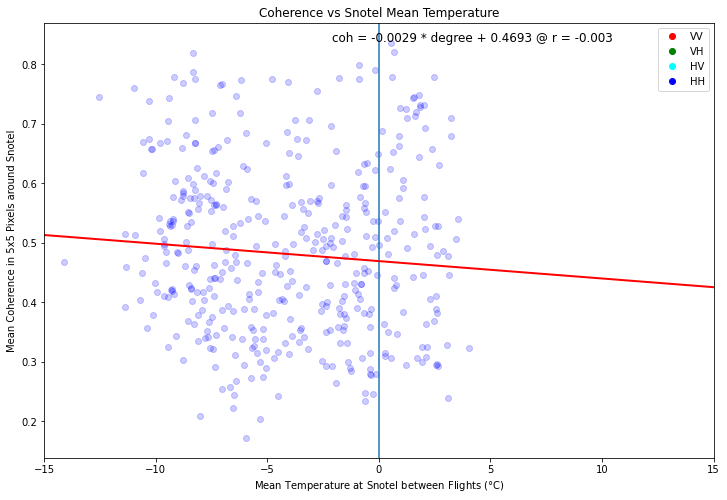

In [16]:
with open(expanduser('~/uavsar/results/coherence/coh_snotel_full/res_df'), 'rb') as f:
    res = pickle.load(f)
f, ax = plt.subplots(figsize = (12,8))
x = []
y = []
for i,r in res.iterrows():
    if r.meso_result:
        for stat in r.meso_result:
            if r.pol == 'VV':
                # d_sd = r.meso_result[stat]['delta_sd']
                d_sd = r.meso_result[stat]['mean_temp']
                x.append(d_sd)
                coh = r.meso_result[stat]['snotel_coh_mean']
                y.append(coh)
                plt.scatter(d_sd, coh, c = pol_cols[r.pol], alpha = 0.2)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
plt.axvline(0)

x = [i for i in x if i is not np.nan]
y = [i for i in y if i is not np.nan]
x = pd.Series(x)
y = pd.Series(y)
lm = HuberRegressor().fit(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel())
r = round(lm.score(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel()), 3)
s =  f'coh = {round(lm.coef_[0], 4)} * degree + {round(lm.intercept_, 4)} @ r = {r}'
plt.text(0.85, 0.98, s, ha='right', va='top', transform=ax.transAxes, fontdict = {'size': 12})
x, y = lm_line(lm, (-15, 15))
plt.plot(x,y, color = pol_cols['VV'], linewidth = 2)

plt.xlabel('Mean Temperature at Snotel between Flights ($\degree$C)')
plt.ylabel('Mean Coherence in 5x5 Pixels around Snotel')
plt.title('Coherence vs Snotel Mean Temperature')
plt.xlim(-15,15)
plt.show()
# plt.savefig(join(fig_dir, 'temp_mean_coh.png'), dpi = 300)

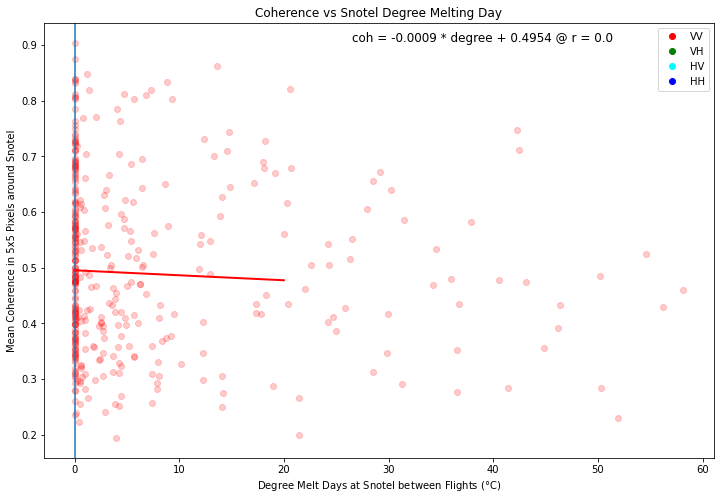

In [17]:
with open(expanduser('~/uavsar/results/coherence/coh_snotel_full/res_df'), 'rb') as f:
    res = pickle.load(f)
f, ax = plt.subplots(figsize = (12,8))
x = []
y = []
for i,r in res.iterrows():
    if r.meso_result:
        for stat in r.meso_result:
            if r.pol == 'VV':
                # d_sd = r.meso_result[stat]['delta_sd']
                d_sd = r.meso_result[stat]['degmeltday']
                x.append(d_sd)
                coh = r.meso_result[stat]['snotel_coh_mean']
                y.append(coh)
                plt.scatter(d_sd, coh, c = pol_cols[r.pol], alpha = 0.2)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
plt.axvline(0)

x = [i for i in x if i is not np.nan]
y = [i for i in y if i is not np.nan]
x = pd.Series(x)
y = pd.Series(y)
lm = HuberRegressor().fit(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel())
r = round(lm.score(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel()), 3)
s =  f'coh = {round(lm.coef_[0], 4)} * degree + {round(lm.intercept_, 4)} @ r = {r}'
plt.text(0.85, 0.98, s, ha='right', va='top', transform=ax.transAxes, fontdict = {'size': 12})
x, y = lm_line(lm, (0, 20))
plt.plot(x,y, color = pol_cols['VV'], linewidth = 2)

plt.xlabel('Degree Melt Days at Snotel between Flights ($\degree$C)')
plt.ylabel('Mean Coherence in 5x5 Pixels around Snotel')
plt.title('Coherence vs Snotel Degree Melting Day')
# plt.xlim(-30,30)
plt.show()
# plt.savefig(join(fig_dir, 'temp_mean_coh.png'), dpi = 300)

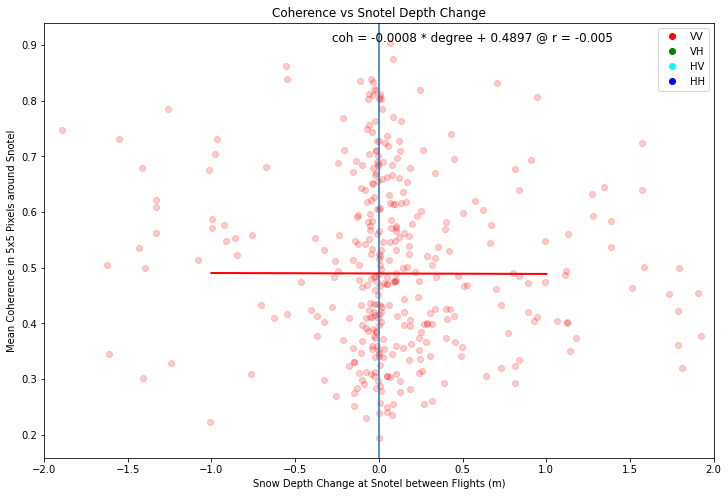

In [21]:
with open(expanduser('~/uavsar/results/coherence/coh_snotel_full/res_df'), 'rb') as f:
    res = pickle.load(f)
f, ax = plt.subplots(figsize = (12,8))
x = []
y = []
for i,r in res.iterrows():
    if r.meso_result:
        for stat in r.meso_result:
            if r.pol == 'VV':
                # d_sd = r.meso_result[stat]['delta_sd']
                d_sd = r.meso_result[stat]['delta_sd']
                x.append(d_sd)
                coh = r.meso_result[stat]['snotel_coh_mean']
                y.append(coh)
                plt.scatter(d_sd, coh, c = pol_cols[r.pol], alpha = 0.2)
markers = [plt.Line2D([0,0],[0,0],color=color, marker='o', linestyle='') for color in pol_cols.values()]
plt.legend(markers, pol_cols.keys(), numpoints=1)
plt.axvline(0)

x = [i for i in x if i is not np.nan]
y = [i for i in y if i is not np.nan]
x = pd.Series(x)
y = pd.Series(y)
lm = HuberRegressor().fit(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel())
r = round(lm.score(x.values[~np.isnan(x.values)].ravel().reshape(-1, 1), y[~np.isnan(x.values)].values.ravel()), 3)
s =  f'coh = {round(lm.coef_[0], 4)} * degree + {round(lm.intercept_, 4)} @ r = {r}'
plt.text(0.85, 0.98, s, ha='right', va='top', transform=ax.transAxes, fontdict = {'size': 12})
x, y = lm_line(lm, (-1, 1))
plt.plot(x,y, color = pol_cols['VV'], linewidth = 2)

plt.xlabel('Snow Depth Change at Snotel between Flights (m)')
plt.ylabel('Mean Coherence in 5x5 Pixels around Snotel')
plt.title('Coherence vs Snotel Depth Change')
plt.xlim(-2,2)
plt.show()
# plt.savefig(join(fig_dir, 'temp_mean_coh.png'), dpi = 300)